In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve, roc_curve, f1_score, precision_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from tqdm import tqdm
from category_encoders.target_encoder import TargetEncoder
pd.options.display.max_columns = None
import warnings
warnings.filterwarnings('ignore')

---

# Problem Statement

Given a set of attributes for an Individual, we need to determine if a credit line should be extended to them. If so, what should the repayment terms be in business recommendations? 

# Insights : 
- 20% of loans disbursed become delinquent
- Geography is the strongest predictor of someone becoming delinquent 
    - Pincode's last 2 digits which signify sectional area is the strongest predictor to be precise
    - 16, 37 and 66 have 100% delinquency rate
    - 08, 51 and 95 have 0% delinquency rate
- We built Logistic Regression model with ROC AUC of 90%, PR AUC of 78% and F1 score of 62%
- Median loan amount for : 
    - Delinquents : 14k
    - Non delinquents : 12k
- 60 month loans (30% delinquent) are twice as risky as 36 month loans (15% delinquent)

# Recommendations : 
- The lending organization should appoint people with high domain knowledge to investigate the reasons behind the high predictive power in pincode. Especially in regions where delinquency is 100%. And for the shorter term the organization to not lend to people from these highly delinquent pincodes.
- If the lending organization further needs to improve its model performance (especially precision) it should look into increasing better datasets like credit bureau records (for eg CIBIL). 
- The lending organization can also build 2 models for the 2 loan terms it offers (36 months, 60 months) because the delinquency for the 5 year loan terms is twice as much as the 3 year loan terms 

---

# EDA

## Non Visual EDA

In [2]:
df = pd.read_csv('logistic_regression.csv')

In [3]:
df.shape

(396030, 27)

In [4]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,Not Verified,Jan-2015,Fully Paid,vacation,Vacation,26.24,Jun-1990,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Debt consolidation,22.05,Jul-2004,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,Source Verified,Jan-2015,Fully Paid,credit_card,Credit card refinancing,12.79,Aug-2007,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,Not Verified,Nov-2014,Fully Paid,credit_card,Credit card refinancing,2.60,Sep-2006,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,Verified,Apr-2013,Charged Off,credit_card,Credit Card Refinance,33.95,Mar-1999,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

In [6]:
df.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
count,396030.000000,396030.000000,396030.000000,3.960300e+05,396030.000000,396030.000000,396030.000000,3.960300e+05,395754.000000,396030.000000,358235.000000,395495.000000
mean,14113.888089,13.639400,431.849698,7.420318e+04,17.379514,11.311153,0.178191,1.584454e+04,53.791749,25.414744,1.813991,0.121648
std,8357.441341,4.472157,250.727790,6.163762e+04,18.019092,5.137649,0.530671,2.059184e+04,24.452193,11.886991,2.147930,0.356174
min,500.000000,5.320000,16.080000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000,0.000000,0.000000
25%,8000.000000,10.490000,250.330000,4.500000e+04,11.280000,8.000000,0.000000,6.025000e+03,35.800000,17.000000,0.000000,0.000000
50%,12000.000000,13.330000,375.430000,6.400000e+04,16.910000,10.000000,0.000000,1.118100e+04,54.800000,24.000000,1.000000,0.000000
75%,20000.000000,16.490000,567.300000,9.000000e+04,22.980000,14.000000,0.000000,1.962000e+04,72.900000,32.000000,3.000000,0.000000
max,40000.000000,30.990000,1533.810000,8.706582e+06,9999.000000,90.000000,86.000000,1.743266e+06,892.300000,151.000000,34.000000,8.000000


In [7]:
df.describe(include='O')

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,purpose,title,earliest_cr_line,initial_list_status,application_type,address
count,396030,396030,396030,373103,377729,396030,396030,396030,396030,396030,394275,396030,396030,396030,396030
unique,2,7,35,173105,11,6,3,115,2,14,48817,684,2,3,393700
top,36 months,B,B3,Teacher,10+ years,MORTGAGE,Verified,Oct-2014,Fully Paid,debt_consolidation,Debt consolidation,Oct-2000,f,INDIVIDUAL,USCGC Smith\r\nFPO AE 70466
freq,302005,116018,26655,4389,126041,198348,139563,14846,318357,234507,152472,3017,238066,395319,8


---

## Visual EDA

### Univariate

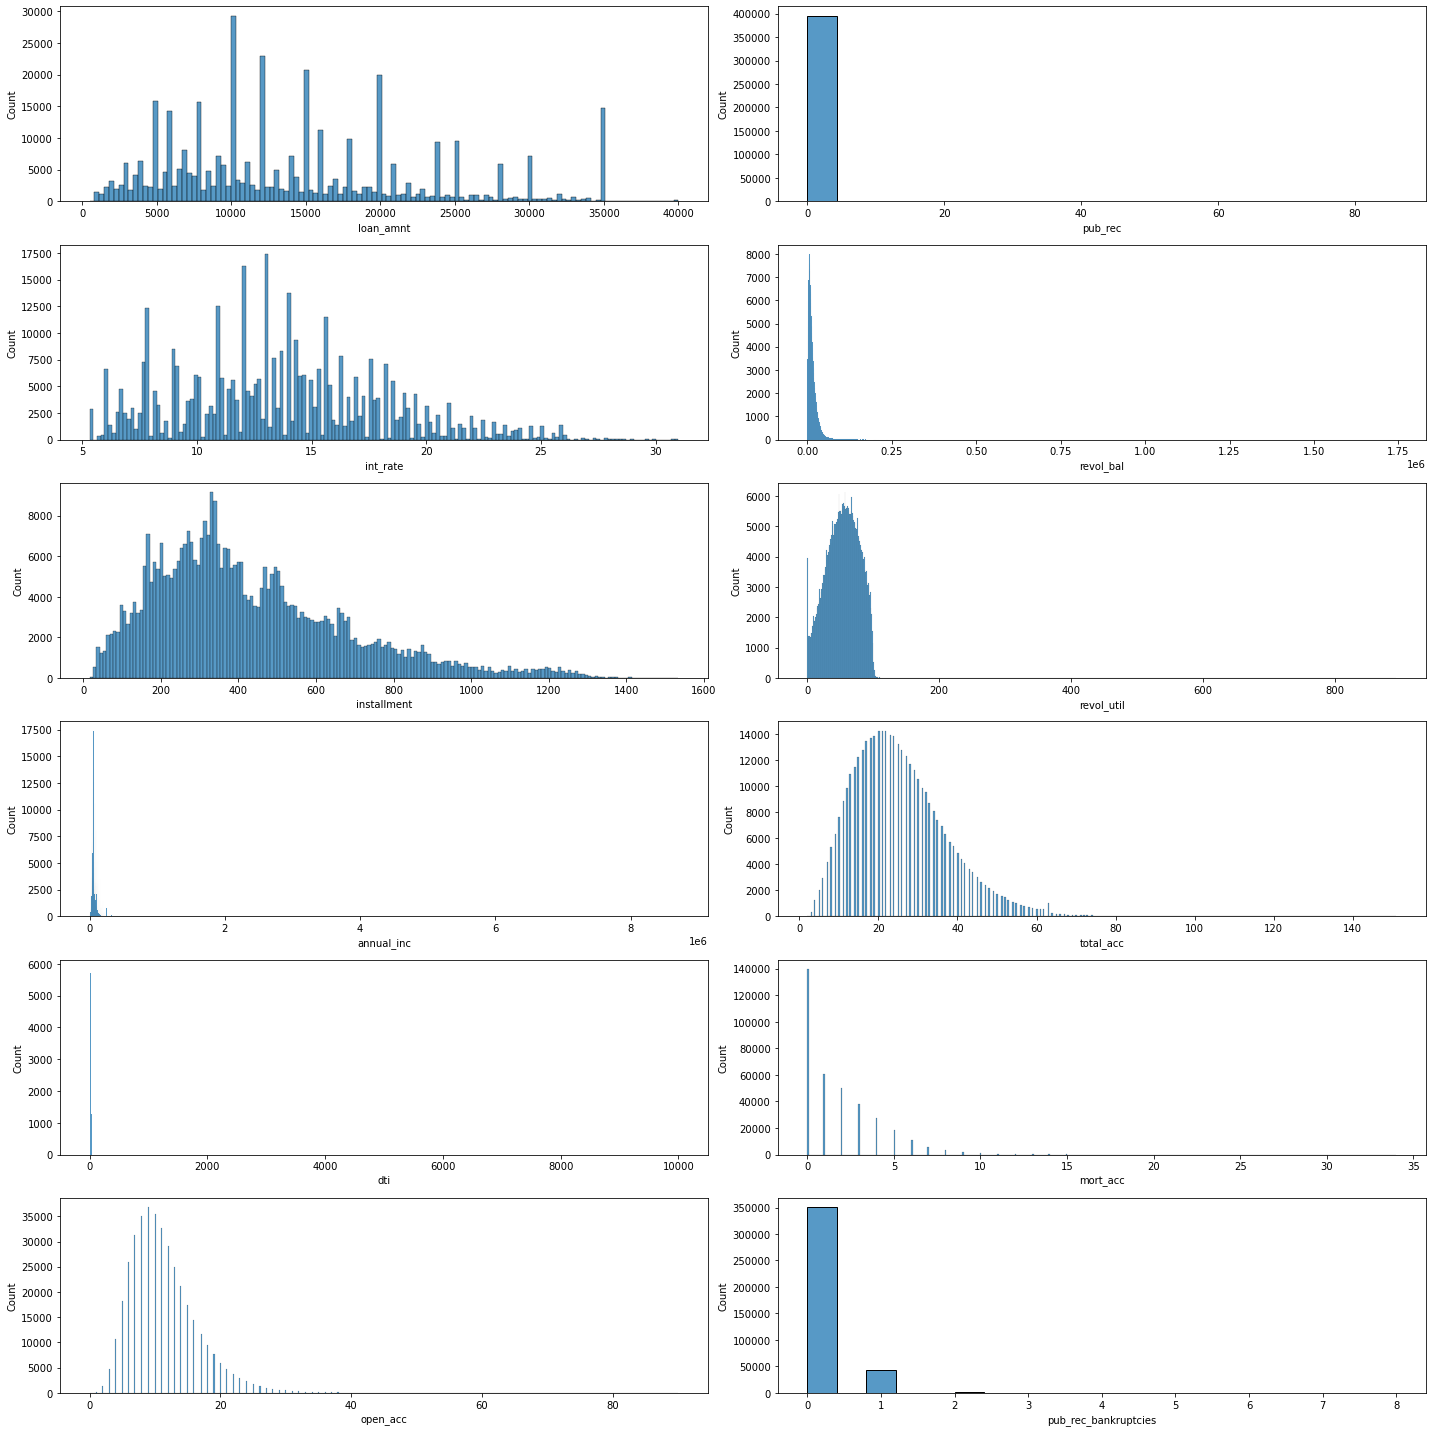

In [8]:
fig,ax = plt.subplots(6,2, figsize=(20,20))
for e, c in enumerate(df.select_dtypes(exclude='O').columns):
    sns.histplot(df[c], ax=ax[e%6][0 if e<6 else 1])
plt.tight_layout()

- Histograms of pub_rec, revol_bal, annual_inc, dti seems to suggest they have outliers. (Right skewed graphs)

15it [00:01,  8.50it/s]


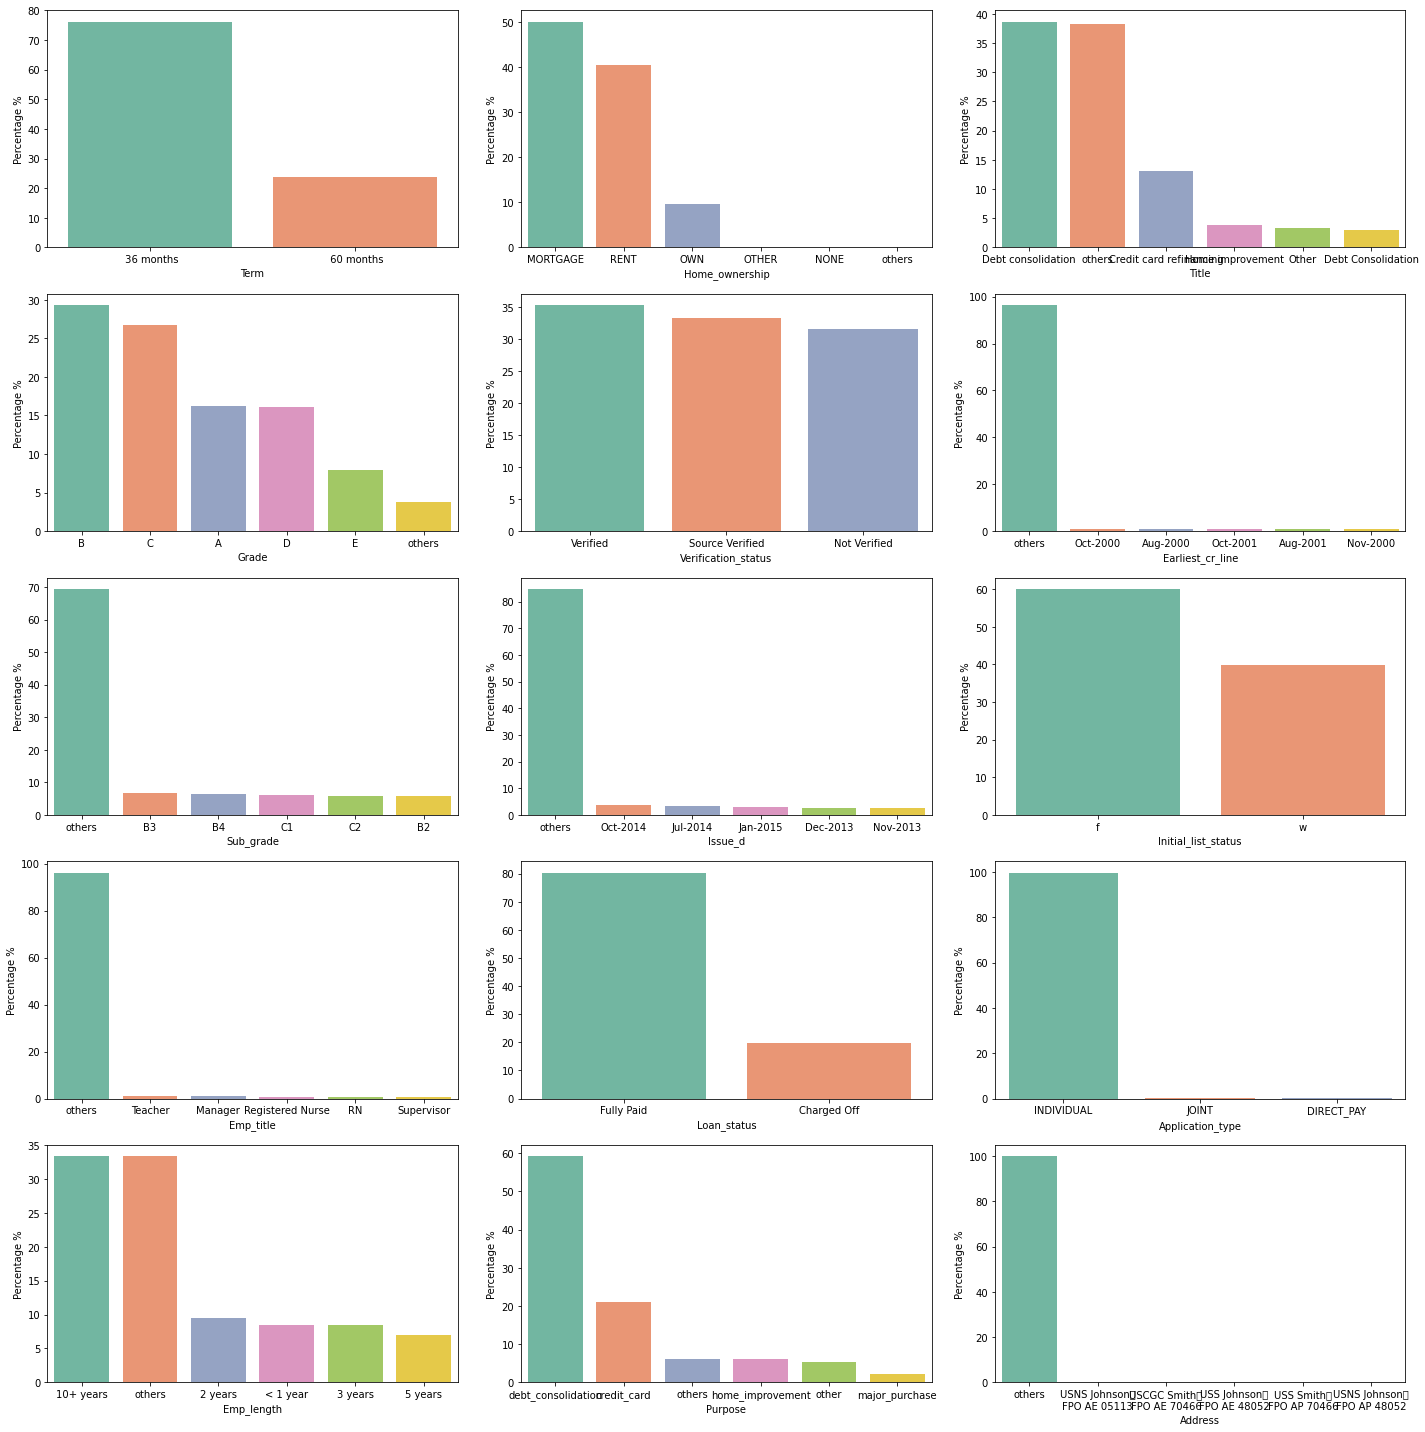

In [9]:
df_ = df.copy()
fig,ax = plt.subplots(5,3, figsize=(20,20))
for e, c in tqdm(enumerate(df_.select_dtypes(include='O').columns)):
    tmp = df_[c].value_counts(1) * 100
    if tmp.shape[0] > 5 : # if there are more than 5 categories, make all others categories to 'others'
        df_.loc[df_[c].isin(tmp.index[5:]),c] = 'others'
        tmp = df_[c].value_counts(1) * 100
    sns.barplot(x=tmp.index, y=tmp.values, ax=ax[e%5][0 if e<5 else 1 if e<10 else 2], palette='Set2')
    ax[e%5][0 if e<5 else 1 if e<10 else 2].set_ylabel('Percentage %')
    ax[e%5][0 if e<5 else 1 if e<10 else 2].set_xlabel(c.capitalize())
plt.tight_layout()

- 80% of loan status is fully paid; 20% is charged off
- 75% of the loans are for 36 months term period

### Bivariate

In [10]:
df_['loan_status'] = df_['loan_status'].replace({'Fully Paid':0, 'Charged Off':1})

<AxesSubplot:>

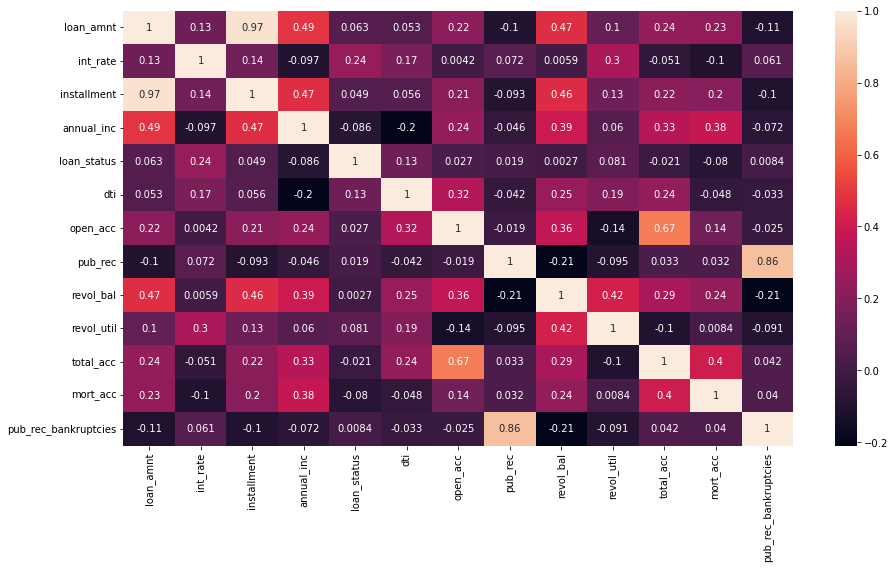

In [11]:
fig, ax = plt.subplots(1,1,figsize=(15,8))
sns.heatmap(df_.corr(method='spearman'), annot=True, ax=ax)

- int_rate has the highest correlation with loan_status (0.24)

---

In [12]:
df_.select_dtypes(include='O').columns

Index(['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'purpose', 'title',
       'earliest_cr_line', 'initial_list_status', 'application_type',
       'address'],
      dtype='object')

14it [00:00, 20.97it/s]


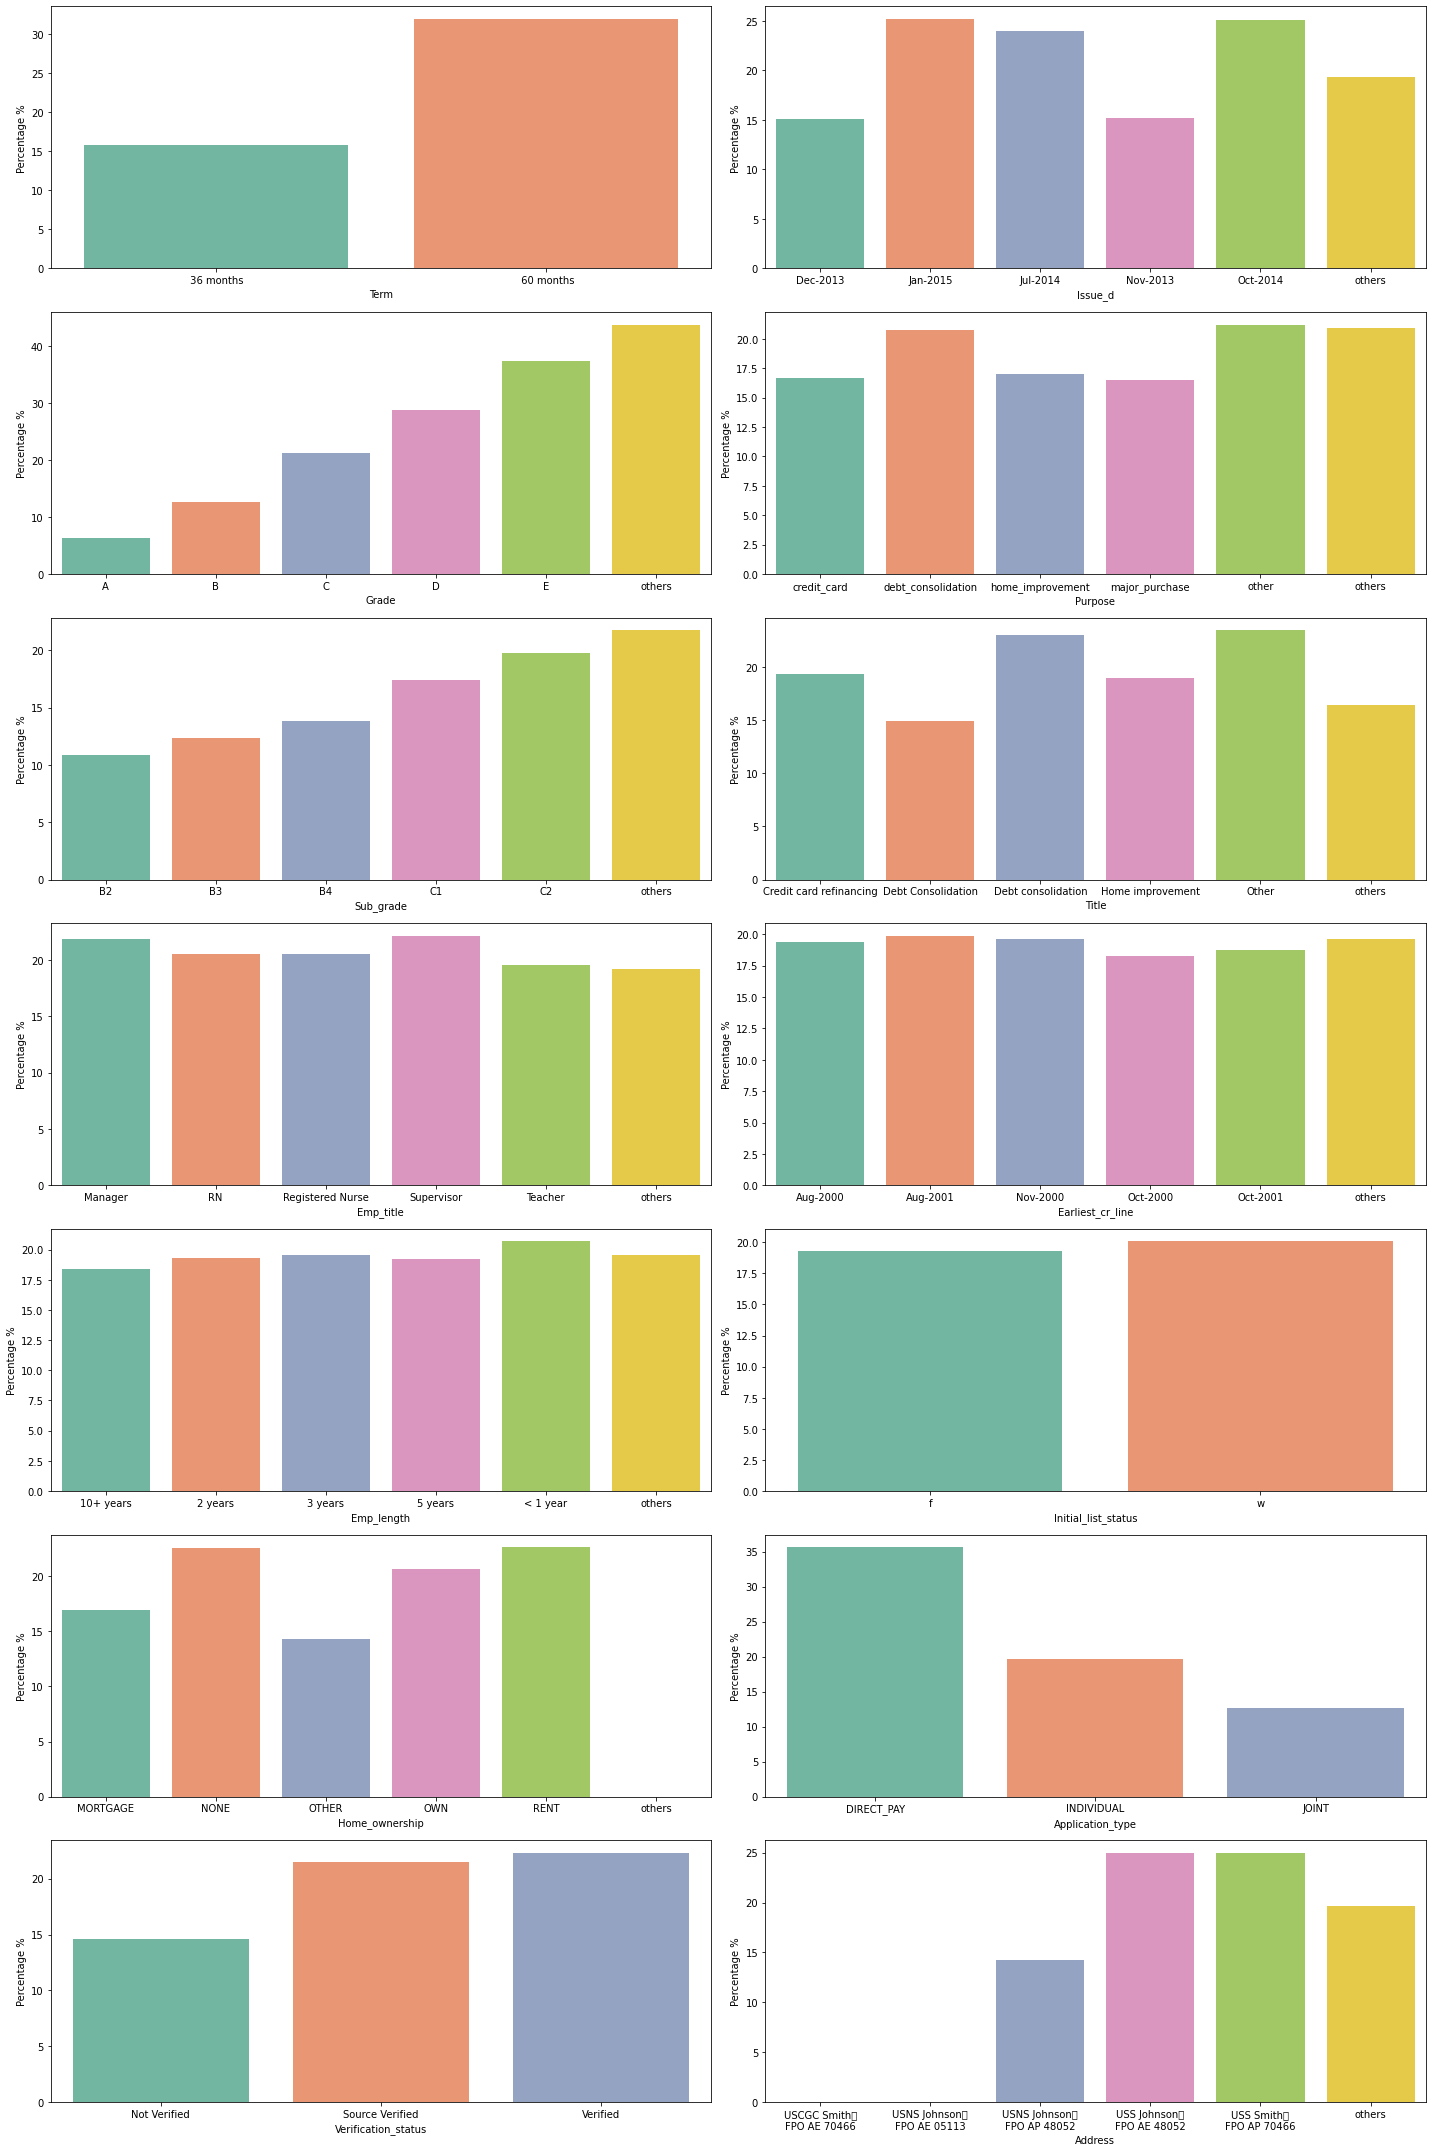

In [15]:
fig, ax = plt.subplots(7,2, figsize=(20,30))
for e, c in tqdm(enumerate(df_.select_dtypes(include='O').columns)):
    tmp = df_[['loan_status',c]]
    tmp = tmp.groupby(c)['loan_status'].mean() * 100
    sns.barplot(x=tmp.index, y=tmp.values, ax=ax[e%7][0 if e<7 else 1], palette='Set2')
    ax[e%7][0 if e<7 else 1].set_ylabel('Percentage %')
    ax[e%7][0 if e<7 else 1].set_xlabel(c.capitalize())
plt.tight_layout()

- 60 months term loans (~ 35%) have double delinquency rate than 30 month term loans (~15%).
- Grade and Subgrade are very good indicators of risk

---

# Data Preprocessing

### Duplicate value check

In [8]:
# no duplicated found
df.duplicated().sum()

0

### Missing value treatment

In [8]:
(df.isna().mean() * 100).sort_values(ascending=False).head()

mort_acc                9.543469
emp_title               5.789208
emp_length              4.621115
title                   0.443148
pub_rec_bankruptcies    0.135091
dtype: float64

In [9]:
df.dtypes.value_counts()

object     15
float64    12
dtype: int64

In [10]:
categorical_cols = list(df.select_dtypes(include='O').columns)
numerical_cols = list(df.select_dtypes(exclude='O').columns)

In [11]:
# filling categorical NaNs with 'missing' string
df.loc[:,categorical_cols] = df.loc[:,categorical_cols].fillna('missing')

In [12]:
# filling numerical NaNs with median values
median = df.loc[:,numerical_cols].median()
df.loc[:,numerical_cols] = df.loc[:,numerical_cols].fillna(median)

In [13]:
# no nulls remaining
df.isna().sum().sum()

0

### Outlier treatment

In [14]:
remove_outliers = lambda df,x : df.loc[(x>=(x.quantile(0.25) - 3*(x.quantile(0.75) - x.quantile(0.25)))) 
                                       & 
                                       (x<=(x.quantile(0.75) + 3*(x.quantile(0.75) - x.quantile(0.25))))]

In [15]:
intial = df.shape[0]
for c in numerical_cols:
    before = df.shape[0]
    df = remove_outliers(df, df[c])
    after = df.shape[0]
    print(f'Outliers dropped due to {c} : {before - after}')
    df = df.reset_index(drop=True)
print(f'Intial Rows : {intial}\t Final Rows : {df.shape[0]}')

Outliers dropped due to loan_amnt : 0
Outliers dropped due to int_rate : 0
Outliers dropped due to installment : 2
Outliers dropped due to annual_inc : 4986
Outliers dropped due to dti : 23
Outliers dropped due to open_acc : 1206
Outliers dropped due to pub_rec : 57045
Outliers dropped due to revol_bal : 5929
Outliers dropped due to revol_util : 1
Outliers dropped due to total_acc : 117
Outliers dropped due to mort_acc : 241
Outliers dropped due to pub_rec_bankruptcies : 0
Intial Rows : 396030	 Final Rows : 326480


### Feature engineering

In [16]:
#Extracting pincode and creating features

df['pincode'] = df['address'].str[-5:]
df = df.drop(columns=['address'])

df['national_area'] = df['pincode'].str[0]
df['sectional_area'] = df['pincode'].str[1:3]
df['delivery_area'] = df['pincode'].str[3:]

df = df.drop(columns=['pincode'])

In [17]:
# Creating features from date columns

df['issue_d'] = pd.to_datetime(df['issue_d'])
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])

df['issue_d_year'] = df['issue_d'].dt.year
df['earliest_cr_line_year'] = df['earliest_cr_line'].dt.year

df['issue_d_month'] = df['issue_d'].dt.month
df['earliest_cr_line_month'] = df['earliest_cr_line'].dt.month

df = df.drop(columns=['issue_d','earliest_cr_line'])

---

In [18]:
# if more than 10 categories present in data, converting them to 'others' category 
categorical_cols = list(df.select_dtypes(include='O').columns)

for c in categorical_cols:
    df[c] = df[c].str.capitalize()
    if df[c].nunique() > 10:
        other_cats = df[c].value_counts().index[10:] 
        df.loc[df[c].isin(other_cats), c] = 'others'

### Data preparation for modeling

In [19]:
df['loan_status'] = df['loan_status'].replace({'Fully paid':0,'Charged off':1})

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['loan_status']),
                                                    df['loan_status'],
                                                    random_state=42,
                                                    test_size=0.33)

# Model building

In [21]:
pipeline = make_pipeline(TargetEncoder(), StandardScaler(), LogisticRegression(class_weight='balanced'))

In [22]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('targetencoder',
                 TargetEncoder(cols=['term', 'grade', 'sub_grade', 'emp_title',
                                     'emp_length', 'home_ownership',
                                     'verification_status', 'purpose', 'title',
                                     'initial_list_status', 'application_type',
                                     'national_area', 'sectional_area',
                                     'delivery_area'])),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced'))])

In [130]:
feat_imps = pd.DataFrame(np.hstack((np.array(X_train.columns).reshape(-1,1),
                                    pipeline['logisticregression'].coef_.reshape(-1,1))),
                        columns=['Feature','Coefficent'])
feat_imps['Coefficent'] = abs(feat_imps['Coefficent'])
feat_imps = feat_imps.sort_values('Coefficent',ascending=False)
feat_imps.head()

,Feature,Coefficent
24,sectional_area,5.601613
25,delivery_area,5.601613
23,national_area,0.725747
4,grade,0.334506
1,term,0.215277


- delivery_area and sectional_area are the most important features with coeffiecients 10x more than other features

In [24]:
pipeline['logisticregression'].get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [25]:
pipeline['logisticregression'].intercept_

array([-0.24546857])

---

# Results Evaluation

In [26]:
preds = pipeline.predict_proba(X_test)[:,1]

### ROC AUC Curve

In [27]:
roc_auc_score(y_test, preds)

0.9081186209417342

In [28]:
fpr, tpr, thresholds = roc_curve(y_test, preds)

Text(0.5, 1.0, 'ROC AUC Curve')

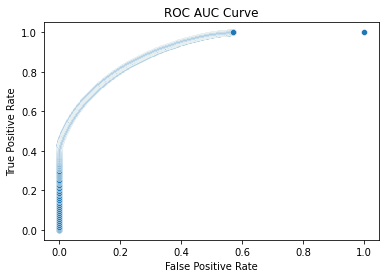

In [29]:
g = sns.scatterplot(fpr,tpr)
g.set_xlabel('False Positive Rate')
g.set_ylabel('True Positive Rate')
g.set_title('ROC AUC Curve')

- ROC AUC score on test data is 0.9 which is quite good

### Precision Recall Curve

In [30]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

In [31]:
auc(recall, precision)

0.779816127763134

Text(0.5, 1.0, 'Precision Recall Curve')

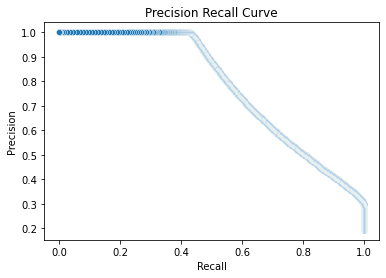

In [32]:
g = sns.scatterplot(recall,precision)
g.set_xlabel('Recall')
g.set_ylabel('Precision')
g.set_title('Precision Recall Curve')

- PR AUC score on test data is 0.78 which is good but not as well as ROC AUC
- There is a sharp decline in Precision beyond Recall of 50%

### Classification Report

In [56]:
print(classification_report(y_test, pipeline.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.81      0.87     86852
           1       0.51      0.80      0.62     20887

    accuracy                           0.81    107739
   macro avg       0.73      0.81      0.75    107739
weighted avg       0.86      0.81      0.82    107739



- f1 score for 0 class is 0.87 and for 1 class is 0.62
- Our model is struggling with precision for bad loans (class 1) -> precision 51%
- The macro average f1 score is 0.75

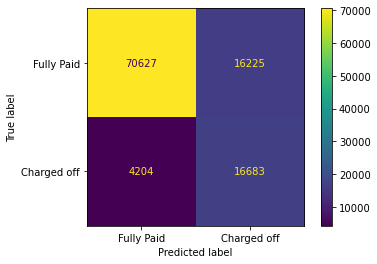

In [64]:
ConfusionMatrixDisplay(confusion_matrix(y_test, pipeline.predict(X_test)),display_labels=['Fully Paid','Charged off']).plot()

- TN : 70k
- TP : 17k
- FP : 16k
- FN : 4k

----

Q... How can we make sure that our model can detect real defaulters and there are less false positives? This is important as we can lose out on an opportunity to finance more individuals and earn interest on it.


A... If we look at the ROC AUC curve below we can see that if we can set a threshold such that FPR is ~0% and TPR is ~40%. So using this thershold we will be able to reduce false positives to nearly 0 and not lose out on opportunity to finance. However the trade off here is that we end up giving loans to a lot of defaulters (60%).

Text(0.5, 1.0, 'ROC AUC Curve')

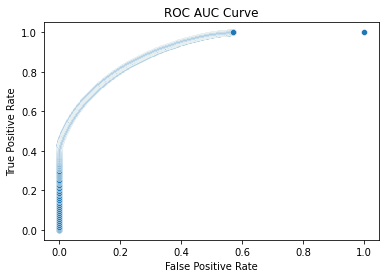

In [29]:
g = sns.scatterplot(fpr,tpr)
g.set_xlabel('False Positive Rate')
g.set_ylabel('True Positive Rate')
g.set_title('ROC AUC Curve')

----

Q... Since NPA (non-performing asset) is a real problem in this industry, it’s important we play safe and shouldn’t disburse loans to anyone. What should we do?

A... If we look at the ROC AUC curve below we can see that if we can set a threshold such that TPR is ~100% and FPR is ~50%. So using this thershold we will be able to catch almost all the defaulters and not have NPAs in our portfolio. However the trade off here is that we lose out on business on a 50% of our rejects

Text(0.5, 1.0, 'ROC AUC Curve')

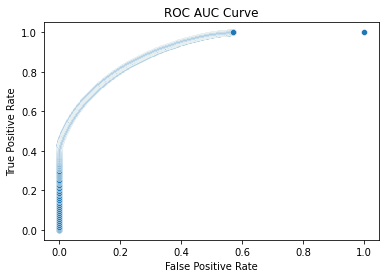

In [69]:
g = sns.scatterplot(fpr,tpr)
g.set_xlabel('False Positive Rate')
g.set_ylabel('True Positive Rate')
g.set_title('ROC AUC Curve')

----

# Misc Analysis

In [116]:
df.groupby('loan_status')['loan_amnt'].median()

loan_status
0    12000.0
1    14000.0
Name: loan_amnt, dtype: float64

In [133]:
df.groupby('sectional_area')['loan_status'].agg(['count','mean']).sort_values('mean')

,count,mean
sectional_area,,
08,37775,0.000000
51,37440,0.000000
95,37514,0.000000
26,46605,0.191825
07,46631,0.193991
04,47020,0.194981
80,46260,0.198227
16,9167,1.000000
37,9065,1.000000


In [135]:
df.groupby('term')['loan_status'].agg(['count','mean']).sort_values('mean')

,count,mean
term,,
36 months,248458,0.155769
60 months,78022,0.318590
